In [1]:
#Download required ntlk packages and lib
import nltk
nltk.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vlad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
from collections import Counter
import re
import math
import html
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

import pymongo
from pymongo import MongoClient
import pprint

%matplotlib inline

In [7]:
#Sentences to try with vader
sentences = ["VADER is smart, handsome, and funny.",
             "Data Scientists are sexy!",
             "The room was dirty and small",
             "They had excellent facilities!",
             "This hotel is the worst hotel in the city"]

In [8]:

#Instantiate an instance to access SentimentIntensityAnalyzer class
sid = SentimentIntensityAnalyzer()

In [9]:
#Vader output
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
         print('{0}: {1}, '.format(k, ss[k]), end='')
    print('\n')

VADER is smart, handsome, and funny.
compound: 0.8316, neg: 0.0, neu: 0.254, pos: 0.746, 

Data Scientists are sexy!
compound: 0.5707, neg: 0.0, neu: 0.448, pos: 0.552, 

The room was dirty and small
compound: -0.4404, neg: 0.367, neu: 0.633, pos: 0.0, 

They had excellent facilities!
compound: 0.6114, neg: 0.0, neu: 0.429, pos: 0.571, 

This hotel is the worst hotel in the city
compound: -0.6249, neg: 0.339, neu: 0.661, pos: 0.0, 



In [38]:
# Read in from pandas
hotelDf = pd.read_csv('boston.csv')
# hotelDf.columns=['id','filePath','hotelName','review','ratingScore','groundTruth']
hotelDf.columns=['filePath','hotelName','review','ratingScore','groundTruth']
hotelDf.head()

,filePath,hotelName,review,ratingScore,groundTruth
0,OUT/com/60745/10169149/399779552.html,Evolve East Boston,"""Agree with previous poster describing this as...",4,positive
1,OUT/com/60745/10169149/617275497.html,Evolve East Boston,"""Evolve East Boston 2132 was perfect for our w...",5,positive
2,OUT/com/60745/10169149/584513693.html,Evolve East Boston,"""We are a family from Denmark who arrived in B...",3,negative
3,OUT/com/60745/10169149/427608075.html,Evolve East Boston,"""Large spacious studio apartment hotel room. H...",4,positive
4,OUT/com/60745/10169149/539042739.html,Evolve East Boston,"""Room excellent, very comfortable bed and all ...",5,positive


In [39]:
hotelDf[hotelDf['review'].str.contains('frily')]

,filePath,hotelName,review,ratingScore,groundTruth


In [40]:
df_filter = pd.read_csv('boston.csv')
# hotelDf.columns=['id','filePath','hotelName','review','ratingScore','groundTruth']
df_filter.columns=['filePath','hotelName','review','ratingScore','groundTruth']
df_filter.head()

,filePath,hotelName,review,ratingScore,groundTruth
0,OUT/com/60745/10169149/399779552.html,Evolve East Boston,"""Agree with previous poster describing this as...",4,positive
1,OUT/com/60745/10169149/617275497.html,Evolve East Boston,"""Evolve East Boston 2132 was perfect for our w...",5,positive
2,OUT/com/60745/10169149/584513693.html,Evolve East Boston,"""We are a family from Denmark who arrived in B...",3,negative
3,OUT/com/60745/10169149/427608075.html,Evolve East Boston,"""Large spacious studio apartment hotel room. H...",4,positive
4,OUT/com/60745/10169149/539042739.html,Evolve East Boston,"""Room excellent, very comfortable bed and all ...",5,positive


In [41]:
df_filter = df_filter.groupby(['hotelName'])['groundTruth'].agg(['count'])
df_filter

,count
hotelName,
463 Beacon Street Guest House,2
"Battery Wharf Hotel, Boston Waterfront",955
Boston Marriott Copley Place,1673
Boston Marriott Long Wharf,1178
Boston Park Plaza,1643
Bostonian Boston,1018
Caj Guest House Tremont Street,24
Copley House,373
Copley Square Hotel,1089


In [42]:
df_filter = df_filter.reset_index()

In [43]:
df_filter = df_filter.loc[df_filter['count']>50]
df_filter

,hotelName,count
1,"Battery Wharf Hotel, Boston Waterfront",955
2,Boston Marriott Copley Place,1673
3,Boston Marriott Long Wharf,1178
4,Boston Park Plaza,1643
5,Bostonian Boston,1018
7,Copley House,373
8,Copley Square Hotel,1089
9,DoubleTree Suites by Hilton Boston - Cambridge,1017
12,Hilton Boston Logan Airport,1922
14,Hyatt Regency Boston,2166


In [44]:
df_filter['hotelName']

1             Battery Wharf Hotel, Boston Waterfront
2                       Boston Marriott Copley Place
3                         Boston Marriott Long Wharf
4                                  Boston Park Plaza
5                                   Bostonian Boston
7                                       Copley House
8                                Copley Square Hotel
9     DoubleTree Suites by Hilton Boston - Cambridge
12                       Hilton Boston Logan Airport
14                              Hyatt Regency Boston
15                               Newbury Guest House
16                                       The Langham
Name: hotelName, dtype: object

In [45]:
hotelDf = pd.merge(hotelDf, df_filter, how='inner', indicator=True)
hotelDf

,filePath,hotelName,review,ratingScore,groundTruth,count,_merge
0,OUT/com/60745/120988/229459717.html,Hilton Boston Logan Airport,"""A very convenient, comfortable, spacious, con...",4,positive,1922,both
1,OUT/com/60745/120988/437956386.html,Hilton Boston Logan Airport,"""I tend to post only positive reviews for plac...",2,negative,1922,both
2,OUT/com/60745/120988/146183900.html,Hilton Boston Logan Airport,"""Stayed in hotel while having a layover. Nothi...",4,positive,1922,both
3,OUT/com/60745/120988/539832503.html,Hilton Boston Logan Airport,"""Wow just got from Switzerland on a terminally...",3,negative,1922,both
4,OUT/com/60745/120988/462154253.html,Hilton Boston Logan Airport,"""This is the perfect hotel. It\\'s linked in t...",5,positive,1922,both
5,OUT/com/60745/120988/566762172.html,Hilton Boston Logan Airport,"""Traveling to Boston from the west coast is a ...",5,positive,1922,both
6,OUT/com/60745/120988/244925040.html,Hilton Boston Logan Airport,"""This is the best airport hotel with a walk wa...",5,positive,1922,both
7,OUT/com/60745/120988/346469965.html,Hilton Boston Logan Airport,"""had to stay here due to flight cancellation. ...",4,positive,1922,both
8,OUT/com/60745/120988/354180662.html,Hilton Boston Logan Airport,"""We got in late and left early -- but this hot...",4,positive,1922,both
9,OUT/com/60745/120988/271474531.html,Hilton Boston Logan Airport,"""The only Boston Logan hotel where one can wal...",5,positive,1922,both


In [46]:
hotelDf['hotelName'].unique()

array(['Hilton Boston Logan Airport', 'The Langham',
       'Newbury Guest House', 'Boston Marriott Copley Place',
       'Boston Park Plaza', 'Copley Square Hotel',
       'Boston Marriott Long Wharf',
       'Battery Wharf Hotel, Boston Waterfront', 'Copley House',
       'Hyatt Regency Boston',
       'DoubleTree Suites by Hilton Boston - Cambridge',
       'Bostonian Boston'], dtype=object)

In [47]:
import re
df2=hotelDf['hotelName'].unique()

hotelStr=[]
for i in df2:
    hotelStr.append(re.sub(r'[.!,;?]', ' ', i).split())
print(hotelStr)

[['Hilton', 'Boston', 'Logan', 'Airport'], ['The', 'Langham'], ['Newbury', 'Guest', 'House'], ['Boston', 'Marriott', 'Copley', 'Place'], ['Boston', 'Park', 'Plaza'], ['Copley', 'Square', 'Hotel'], ['Boston', 'Marriott', 'Long', 'Wharf'], ['Battery', 'Wharf', 'Hotel', 'Boston', 'Waterfront'], ['Copley', 'House'], ['Hyatt', 'Regency', 'Boston'], ['DoubleTree', 'Suites', 'by', 'Hilton', 'Boston', '-', 'Cambridge'], ['Bostonian', 'Boston']]


In [48]:
flat_list = [item for sublist in hotelStr for item in sublist]
flat_list

['Hilton',
 'Boston',
 'Logan',
 'Airport',
 'The',
 'Langham',
 'Newbury',
 'Guest',
 'House',
 'Boston',
 'Marriott',
 'Copley',
 'Place',
 'Boston',
 'Park',
 'Plaza',
 'Copley',
 'Square',
 'Hotel',
 'Boston',
 'Marriott',
 'Long',
 'Wharf',
 'Battery',
 'Wharf',
 'Hotel',
 'Boston',
 'Waterfront',
 'Copley',
 'House',
 'Hyatt',
 'Regency',
 'Boston',
 'DoubleTree',
 'Suites',
 'by',
 'Hilton',
 'Boston',
 '-',
 'Cambridge',
 'Bostonian',
 'Boston']

In [49]:
# for i in hotelDf['hotelName'].unique():
for i in flat_list:
    hotelDf['review'] = hotelDf["review"].str.replace(i, " ", case = False)
hotelDf['review']


0        "A very convenient, comfortable, spacious, con...
1        "I tend to post only positive reviews for  s I...
2        "Stayed in   while having a layover. Nothing s...
3        "Wow just got from Switzerland on a terminally...
4        "This is   perfect  . It\\'s linked in to     ...
5        "Traveling to   from   west coast is a   day. ...
6        "This is   best     with a walk way from     d...
7        "had to stay here due to flight cancellation. ...
8        "We got in late and left early    but this   w...
9        "  only       where one can walk to most of   ...
10       "We were bumped on a flight on Delta and given...
11       "I stayed at this   for a short night as I had...
12       "I stayed in room 832 on June 13 in order to b...
13       "Great views of     and   city skyline and har...
14       "    is great for late night arrival.     gym ...
15       "    Is Well Kept And Very Classical In Design...
16       "            is ideally located for an early m.

In [50]:
# specialChar = ['u0430','u043d','u043e']
# hotelDf['review'] = hotelDf["review"].str.replace("\\u2019", "'", case = False)
# hotelDf['review'] = hotelDf['review'].str.replace(j,"")
# hotelDf

# \\u041e\\u0447\\u0435\\u043d\\u044c \\u0441\\u043e\\u0432\\u0440\\u0435\\u043c\\u0435\\u043d\\u043d\\u044b\\u0439, \\u043d\\u043e\\u0432\\u044b\\u0439, \\u0441\\u043a\\u043e\\u0440\\u043e\\u0441\\u0442\\u043d\\u044b\\u0435 \\u043b\\u0438\\u0444\\u0442\\u044b, \\u043e\\u0431\\u0437\\u043e\\u0440\\u043d\\u0430\\u044f \\u043f\\u043b\\u043e\\u0449\\u0430\\u0434\\u043a\\u0430 \\u043d\\u0430\\u0432\\u0435\\u0440\\u0445\\u0443 \\u0437\\u0434\\u0430\\u043d\\u0438\\u044f, \\u043e\\u0442\\u043b\\u0438\\u0447\\u043d\\u044b\\u0435 \\u0432\\u0438\\u0434\\u044b \\u0438\\u0437 \\u043e\\u043a\\u043d\\u0430 \\u043d\\u043e\\u043c\\u0435\\u0440\\u0430, \\u0440\\u0430\\u0441\\u043f\\u043e\\u043b\\u043e\\u0436\\u0435\\u043d\\u0438\\u0435 \\u0438\\u0434\\u0435\\u0430\\u043b\\u044c\\u043d\\u043e\\u0435, \\u043f\\u0440\\u0438\\u0432\\u0435\\u0442\\u043b\\u0438\\u0432\\u044b\\u0439 \\u0438 \\u0432\\u0435\\u0436\\u043b\\u0438\\u0432\\u044b\\u0439 \\u043f\\u0435\\u0440\\u0441\\u043e\\u043d\\u0430\\u043b, \\u0443\\u0434\\u043e\\u0431\\u043d\\u0430\\u044f \\u043f\\u0440\\u043e\\u0441\\u0442\\u043e\\u0440\\u043d\\u0430\\u044f \\u043a\\u0440\\u043e\\u0432\\u0430\\u0442\\u044c, \\u043f\\u0440\\u0435\\u043a\\u0440\\u0430\\u0441\\u043d\\u0430\\u044f \\u0437\\u0432\\u0443\\u043a\\u043e\\u0438\\u0437\\u043e\\u043b\\u044f\\u0446\\u0438\\u044f, \\u0432 \\u043d\\u043e\\u043c\\u0435\\u0440\\u0435 \\u043c\\u0438\\u043a\\u0440\\u043e\\u0432\\u043e\\u043b\\u043d\\u043e\\u0432\\u043a\\u0430, \\u043a\\u043e\\u0444\\u0435-\\u043c\\u0430\\u0448\\u0438\\u043d\\u0430, 

In [51]:
# There are unparsed html tags in the hotelnames. We can change the html tags to ascii equivalents by using the following code.
for i in range(len(hotelDf)):
    hotelname = hotelDf.at[i, 'hotelName']
    hotelname = hotelname.encode("utf-8")
    hotelname = hotelname.decode("ascii", "ignore")
#     hotelname = hotelname.decode("ascii", "namereplace")
    hotelname = html.unescape(hotelname)
    hotelDf.at[i, 'hotelName'] = hotelname

In [52]:
# specialChar = ['u0430','u043d','u043e']
hotelDf['review'] = hotelDf["review"].str.replace("\\u2019", "'", case = False)
hotelDf['review'] = hotelDf["review"].str.replace("u2019", "'", case = False)
hotelDf['review'] = hotelDf["review"].str.replace(" ei ", "", case = False)
hotelDf['review'] = hotelDf["review"].str.replace("bo red", "bored", case = False)

# hotelDf['review'] = hotelDf["review"].str.replace("tribeca", "'", case = False)
# hotelDf['review'] = hotelDf["review"].str.replace("  u2019", "'", case = False)
# hotelDf['review'] = hotelDf['review'].str.replace(j,"")
# hotelDf
locationName = ['tribeca','Tribeca','Times Square', 'Timessquare','timessquare','times square',
                'grand central', 'Grand Central','chelsea','Chelsea','hudson','river','Hudson', 'River', 'Empire', 'empire', 'central park', 'Central park', 'Central Park', 'building', 'Building']

for z in locationName:
    hotelDf['review'] = hotelDf["review"].str.replace(z,"", case = False)

specialChar = '\\u041e\\u0447\\u0435\\u043d\\u044c \\u0441\\u043e\\u0432\\u0440\\u0435\\u043c\\u0435\\u043d\\u043d\\u044b\\u0439, \\u043d\\u043e\\u0432\\u044b\\u0439, \\u0441\\u043a\\u043e\\u0440\\u043e\\u0441\\u0442\\u043d\\u044b\\u0435 \\u043b\\u0438\\u0444\\u0442\\u044b, \\u043e\\u0431\\u0437\\u043e\\u0440\\u043d\\u0430\\u044f \\u043f\\u043b\\u043e\\u0449\\u0430\\u0434\\u043a\\u0430 \\u043d\\u0430\\u0432\\u0435\\u0440\\u0445\\u0443 \\u0437\\u0434\\u0430\\u043d\\u0438\\u044f, \\u043e\\u0442\\u043b\\u0438\\u0447\\u043d\\u044b\\u0435 \\u0432\\u0438\\u0434\\u044b \\u0438\\u0437 \\u043e\\u043a\\u043d\\u0430 \\u043d\\u043e\\u043c\\u0435\\u0440\\u0430, \\u0440\\u0430\\u0441\\u043f\\u043e\\u043b\\u043e\\u0436\\u0435\\u043d\\u0438\\u0435 \\u0438\\u0434\\u0435\\u0430\\u043b\\u044c\\u043d\\u043e\\u0435, \\u043f\\u0440\\u0438\\u0432\\u0435\\u0442\\u043b\\u0438\\u0432\\u044b\\u0439 \\u0438 \\u0432\\u0435\\u0436\\u043b\\u0438\\u0432\\u044b\\u0439 \\u043f\\u0435\\u0440\\u0441\\u043e\\u043d\\u0430\\u043b, \\u0443\\u0434\\u043e\\u0431\\u043d\\u0430\\u044f \\u043f\\u0440\\u043e\\u0441\\u0442\\u043e\\u0440\\u043d\\u0430\\u044f \\u043a\\u0440\\u043e\\u0432\\u0430\\u0442\\u044c, \\u043f\\u0440\\u0435\\u043a\\u0440\\u0430\\u0441\\u043d\\u0430\\u044f \\u0437\\u0432\\u0443\\u043a\\u043e\\u0438\\u0437\\u043e\\u043b\\u044f\\u0446\\u0438\\u044f, \\u0432 \\u043d\\u043e\\u043c\\u0435\\u0440\\u0435 \\u043c\\u0438\\u043a\\u0440\\u043e\\u0432\\u043e\\u043b\\u043d\\u043e\\u0432\\u043a\\u0430, \\u043a\\u043e\\u0444\\u0435-\\u043c\\u0430\\u0448\\u0438\\u043d\\u0430,'.split("\\")
for j in specialChar:
    hotelDf['review'] = hotelDf['review'].str.replace(j,"")
hotelDf

,filePath,hotelName,review,ratingScore,groundTruth,count,_merge
0,OUT/com/60745/120988/229459717.html,Hilton Boston Logan Airport,"""A very convenient, comfortable, spacious, con...",4,positive,1922,both
1,OUT/com/60745/120988/437956386.html,Hilton Boston Logan Airport,"""I tend to post only positive reviews for s I...",2,negative,1922,both
2,OUT/com/60745/120988/146183900.html,Hilton Boston Logan Airport,"""Stayed in while having a layover. Nothing s...",4,positive,1922,both
3,OUT/com/60745/120988/539832503.html,Hilton Boston Logan Airport,"""Wow just got from Switzerland on a terminally...",3,negative,1922,both
4,OUT/com/60745/120988/462154253.html,Hilton Boston Logan Airport,"""This is perfect . It\\'s linked in to ...",5,positive,1922,both
5,OUT/com/60745/120988/566762172.html,Hilton Boston Logan Airport,"""Traveling to from west coast is a day. ...",5,positive,1922,both
6,OUT/com/60745/120988/244925040.html,Hilton Boston Logan Airport,"""This is best with a walk way from d...",5,positive,1922,both
7,OUT/com/60745/120988/346469965.html,Hilton Boston Logan Airport,"""had to stay here due to flight cancellation. ...",4,positive,1922,both
8,OUT/com/60745/120988/354180662.html,Hilton Boston Logan Airport,"""We got in late and left early but this w...",4,positive,1922,both
9,OUT/com/60745/120988/271474531.html,Hilton Boston Logan Airport,""" only where one can walk to most of ...",5,positive,1922,both


In [53]:
# specialChar.append(re.sub(r'[\\,]', ' ', i).split())

In [54]:

# Initialize  the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

In [55]:
vaderScores = []
#Assign Vader score to individual review using Vader compound score
for rownum, review in enumerate(hotelDf['review']):
    scores = sid.polarity_scores(review)
    vaderScores.append(scores['compound'])
    if (rownum % 1000 == 0):
            print("processed %d reviews" % (rownum+1))
print("completed")

processed 1 reviews
processed 1001 reviews
processed 2001 reviews
processed 3001 reviews
processed 4001 reviews
processed 5001 reviews
processed 6001 reviews
processed 7001 reviews
processed 8001 reviews
processed 9001 reviews
processed 10001 reviews
processed 11001 reviews
processed 12001 reviews
processed 13001 reviews
processed 14001 reviews
completed


In [56]:
hotelDf

,filePath,hotelName,review,ratingScore,groundTruth,count,_merge
0,OUT/com/60745/120988/229459717.html,Hilton Boston Logan Airport,"""A very convenient, comfortable, spacious, con...",4,positive,1922,both
1,OUT/com/60745/120988/437956386.html,Hilton Boston Logan Airport,"""I tend to post only positive reviews for s I...",2,negative,1922,both
2,OUT/com/60745/120988/146183900.html,Hilton Boston Logan Airport,"""Stayed in while having a layover. Nothing s...",4,positive,1922,both
3,OUT/com/60745/120988/539832503.html,Hilton Boston Logan Airport,"""Wow just got from Switzerland on a terminally...",3,negative,1922,both
4,OUT/com/60745/120988/462154253.html,Hilton Boston Logan Airport,"""This is perfect . It\\'s linked in to ...",5,positive,1922,both
5,OUT/com/60745/120988/566762172.html,Hilton Boston Logan Airport,"""Traveling to from west coast is a day. ...",5,positive,1922,both
6,OUT/com/60745/120988/244925040.html,Hilton Boston Logan Airport,"""This is best with a walk way from d...",5,positive,1922,both
7,OUT/com/60745/120988/346469965.html,Hilton Boston Logan Airport,"""had to stay here due to flight cancellation. ...",4,positive,1922,both
8,OUT/com/60745/120988/354180662.html,Hilton Boston Logan Airport,"""We got in late and left early but this w...",4,positive,1922,both
9,OUT/com/60745/120988/271474531.html,Hilton Boston Logan Airport,""" only where one can walk to most of ...",5,positive,1922,both


In [57]:
# Assign vader scores in the original df
hotelDf = hotelDf.assign(vaderScore = vaderScores)
hotelDf.head()

,filePath,hotelName,review,ratingScore,groundTruth,count,_merge,vaderScore
0,OUT/com/60745/120988/229459717.html,Hilton Boston Logan Airport,"""A very convenient, comfortable, spacious, con...",4,positive,1922,both,0.7642
1,OUT/com/60745/120988/437956386.html,Hilton Boston Logan Airport,"""I tend to post only positive reviews for s I...",2,negative,1922,both,0.9056
2,OUT/com/60745/120988/146183900.html,Hilton Boston Logan Airport,"""Stayed in while having a layover. Nothing s...",4,positive,1922,both,0.8966
3,OUT/com/60745/120988/539832503.html,Hilton Boston Logan Airport,"""Wow just got from Switzerland on a terminally...",3,negative,1922,both,0.6945
4,OUT/com/60745/120988/462154253.html,Hilton Boston Logan Airport,"""This is perfect . It\\'s linked in to ...",5,positive,1922,both,0.4199


In [58]:
ratingByHotel = hotelDf.groupby(['hotelName']).mean()['ratingScore'].reset_index()
vaderByHotel = hotelDf.groupby(['hotelName']).mean()['vaderScore'].reset_index()

In [59]:
#RATINGS
ratingByHotel = ratingByHotel.sort_values('ratingScore', ascending=False)
ratingByHotel

,hotelName,ratingScore
11,The Langham,4.445156
0,"Battery Wharf Hotel, Boston Waterfront",4.365445
4,Bostonian Boston,4.305501
6,Copley Square Hotel,4.304867
2,Boston Marriott Long Wharf,4.221562
10,Newbury Guest House,4.202346
9,Hyatt Regency Boston,4.141274
7,DoubleTree Suites by Hilton Boston - Cambridge,4.087512
3,Boston Park Plaza,4.010956
1,Boston Marriott Copley Place,3.992827


In [60]:
# VADER
vaderByHotel = vaderByHotel.sort_values('vaderScore', ascending=False)
vaderByHotel

,hotelName,vaderScore
10,Newbury Guest House,0.848626
6,Copley Square Hotel,0.846395
11,The Langham,0.844578
4,Bostonian Boston,0.835637
2,Boston Marriott Long Wharf,0.821731
0,"Battery Wharf Hotel, Boston Waterfront",0.806823
9,Hyatt Regency Boston,0.755202
1,Boston Marriott Copley Place,0.749841
7,DoubleTree Suites by Hilton Boston - Cambridge,0.735079
3,Boston Park Plaza,0.731678


In [61]:
#Limited Sample size but it appears that 
# ratingScore and vaderScore are positively correlated 
# 

In [62]:
#1. Word Frequency: While not as effective, still running the code!
def get_topk_ngram(df, ngram_range=(1,1), k=None, stopwords=True, with_count=False):
    '''
    Extract the most frequently occurred words in countvector
    '''
    if stopwords:
        temp = []
        for name in hotelDf.hotelName.unique():
            for token in name.split():
                if len(token) > 1:
                    temp.append(token)
        my_stop_words = ENGLISH_STOP_WORDS.union(temp)
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=my_stop_words, max_features=500)
        
    else:
        vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words=None, max_features=k)
        
    countvector = vectorizer.fit_transform(df['review'])

    # Get topk occurred ngrams
    topk_words = []
    sortedindices = countvector.toarray().sum(axis=0).argsort()[::-1][:k]
    counts = countvector.toarray().sum(axis=0)
    
    for i in sortedindices:
        word = vectorizer.get_feature_names()[i]
        
        if with_count:
            count = counts[i]
            topk_words.append((word, count))
        else:
            topk_words.append(word)
            
    return topk_words

In [63]:
topkTotal = get_topk_ngram(hotelDf, k=500)
topkTotal_bigram = get_topk_ngram(hotelDf, ngram_range=(2,2), k=500)
topkPos = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(1,1), k=10, with_count=True)
topkNeg = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(1,1), k=10, with_count=True)
topkPos_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='positive'], ngram_range=(2,2), k=10, with_count=True)
topkNeg_bigram = get_topk_ngram(hotelDf.loc[hotelDf['groundTruth']=='negative'], ngram_range=(2,2), k=10, with_count=True)

print("The most frequently occured top 10 words in positive reviews")
pprint(pd.DataFrame(topkPos, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 words in negative reviews")
pprint(pd.DataFrame(topkNeg, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in positive reviews")
pprint(pd.DataFrame(topkPos_bigram, columns=['Word', 'Count']))

print("\nThe most frequently occured top 10 bigrams in negative reviews")
pprint(pd.DataFrame(topkNeg_bigram, columns=['Word', 'Count']))

/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['airport', 'battery', 'boston', 'bostonian', 'cambridge', 'copley', 'doubletree', 'guest', 'hilton', 'hotel', 'house', 'hyatt', 'langham', 'logan', 'long', 'marriott', 'newbury', 'park', 'place', 'plaza', 'regency', 'square', 'suites', 'waterfront', 'wharf'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/vlad/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['airport', 'battery', 'boston', 'bostonian', 'cambridge', 'copley', 'doubletree', 'guest', 'hilton', 'hotel', 'house', 'hyatt', 'langham', 'logan', 'long', 'marriott', 'newbury', 'park', 'place', 'plaza', 'regency', 'square', 'suites', 'waterfront', 'wharf'] not in 

The most frequently occured top 10 words in positive reviews


TypeError: 'module' object is not callable

In [ ]:
#2. Mutual Information


# positive = 1 / negative = 0
gtScore = []
for i in range(len(hotelDf)):
    if hotelDf['groundTruth'][i] == 'positive':
        gtScore.append(1)
    else:
        gtScore.append(0)

In [ ]:
# let's calculate Mutual Information for unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
    
# miScore_unigram = pd.DataFrame(data = {'word': vectorizer.get_feature_names(),
#              'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]})

miScore_unigram = pd.DataFrame(data =
                               {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]}
                              , index = vectorizer.get_feature_names())

# Bigram version
vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=500)
countvector = vectorizer.fit_transform(hotelDf['review'])
densevector = np.array(countvector.todense())
miScore_bigram = pd.DataFrame(data =
                    {'MI Score': [mutual_info_score(gtScore, densevector[:,i].squeeze()) for i in range(500)]},
                    index = vectorizer.get_feature_names())

In [ ]:

miScore_unigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Unigram')
miScore_unigram.head(10)

In [35]:
miScore_bigram.sort_values('MI Score', inplace=True, ascending=False)
print('Mutual Information - Bigram')
miScore_bigram.head(10)

Mutual Information - Bigram


,MI Score
definitely stay,0.007435
highly recommend,0.006715
walking distance,0.005373
didn work,0.004682
ano room,0.003852
called desk,0.003829
north end,0.003651
quincy market,0.003204
great stay,0.003092
said quot,0.003085


In [36]:
#3. Pointwise Mutual Information

def getPMI_ngram(df, gt, ngram_range=(1,1), max_features=500):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=max_features)
    countvector = vectorizer.fit_transform(hotelDf['review'])
    densevector = np.array(countvector.todense())
    
    px = sum(df['groundTruth'] == gt) / len(df)
    pmis = []
    
    for i in range(max_features):
        py = sum(densevector[:,i] == 1) / len(df)
        pxy = len(df[(df['groundTruth'] == gt) & (densevector[:,i] == 1)]) / len(df)
        
        if pxy == 0:
            pmi = math.log10((pxy + 0.0001) / (px * py))
        else:
            pmi = math.log10(pxy / (px * py))
            
        pmis.append(pmi)
        
    pmis = pd.DataFrame(data = {'pmi' + gt: pmis}, index = vectorizer.get_feature_names())
    return pmis.sort_values('pmi' + gt, ascending=False)

In [37]:
pmiPos_unigram = getPMI_ngram(hotelDf, 'positive')
pmiNeg_unigram = getPMI_ngram(hotelDf, 'negative')
pmiPos_bigram = getPMI_ngram(hotelDf, 'positive', ngram_range=(2,2))
pmiNeg_bigram = getPMI_ngram(hotelDf, 'negative', ngram_range=(2,2))

In [38]:
print('PMI for positive reviews - Unigram')
pmiPos_unigram.head(10)

PMI for positive reviews - Unigram


,pmipositive
highly,0.086650
delicious,0.075117
trail,0.072020
chocolate,0.071628
amazing,0.071394
freedom,0.070966
loved,0.070304
fenway,0.069792
perfect,0.068955
wonderful,0.068054


In [39]:

print('PMI for positive reviews - Bigram')
pmiPos_bigram.head(10)

PMI for positive reviews - Bigram


,pmipositive
highly recommended,0.100870
staff amazing,0.100870
definitely return,0.100870
spacious comfortable,0.100870
definitely recommend,0.096346
wonderful stay,0.095542
highly recommend,0.094436
definitely stay,0.094339
pleasantly surprised,0.093446
went ir,0.091111


In [40]:
print('PMI for negative reviews - Unigram')
pmiNeg_unigram.head(10)

PMI for negative reviews - Unigram


,pminegative
poor,0.513024
wall,0.428208
walls,0.423541
told,0.421413
tiny,0.413967
tried,0.409184
charged,0.408553
ok,0.396429
loud,0.389377
paid,0.387506


In [41]:
print('PMI for negative reviews - Bigram')
pmiNeg_bigram.head(10)

PMI for negative reviews - Bigram


,pminegative
didn work,0.558542
said quot,0.540058
told room,0.503494
ano room,0.484249
did work,0.466771
called desk,0.465424
credit card,0.442218
went desk,0.440442
room quot,0.432941
new room,0.432755


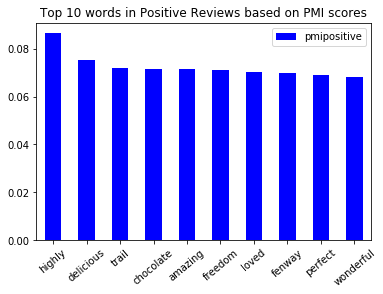

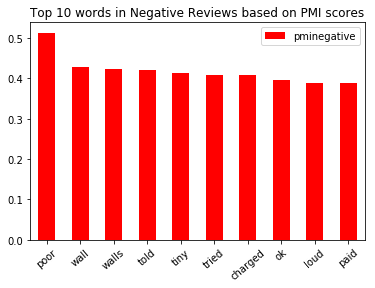

In [42]:
pmiPos_unigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_unigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

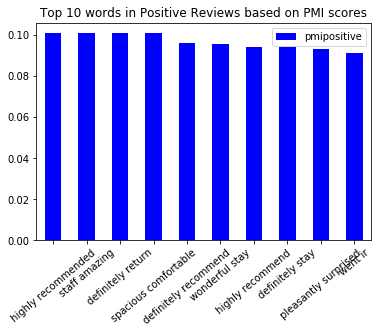

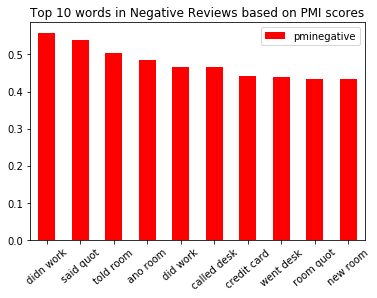

In [43]:
pmiPos_bigram.head(10).plot.bar(rot=40, color='b',
                                 title='Top 10 words in Positive Reviews based on PMI scores')
pmiNeg_bigram.head(10).plot.bar(rot=40, color='r',
                                 title='Top 10 words in Negative Reviews based on PMI scores')
plt.show()

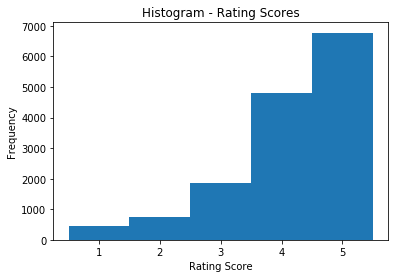

In [44]:
#Visualizations

#Histogram

plt.xlabel('Rating Score')
hotelDf['ratingScore'].plot(kind='hist', title='Histogram - Rating Scores',
                            bins=np.arange(1,7)-0.5)
plt.show()

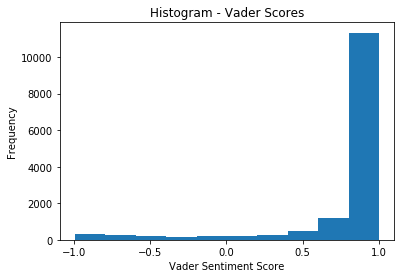

In [45]:

plt.xlabel('Vader Sentiment Score')
hotelDf['vaderScore'].plot(kind='hist', title='Histogram - Vader Scores', 
                           xticks=[-1.0, -0.5, 0.0, 0.5, 1.0])
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


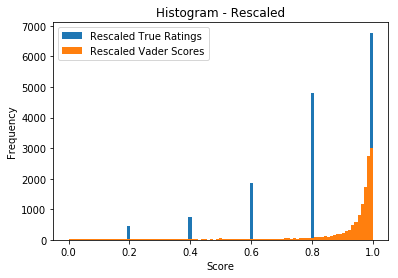

In [46]:
#Overlayed Histogram for GT rating and VD score
#Just for demonstrating, I am dividing the rating score by 5
x = [hotelDf['ratingScore'].as_matrix() / 5]
y = [(hotelDf['vaderScore'].as_matrix() + 1 )/ 2]
bins = np.linspace(0, 1, 100)
plt.hist(x, bins, label='Rescaled True Ratings')
plt.hist(y, bins, label='Rescaled Vader Scores')
plt.title('Histogram - Rescaled')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

In [47]:
#Boxplot

#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = ratingByHotel.sort_values('ratingScore', ascending=False).head(5).hotelName.as_matrix()

tempdf = hotelDf[(hotelDf.hotelName == tp5gthotel[0]) | (hotelDf.hotelName == tp5gthotel[1]) | 
         (hotelDf.hotelName == tp5gthotel[2]) | (hotelDf.hotelName == tp5gthotel[3]) | 
         (hotelDf.hotelName == tp5gthotel[4])]

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


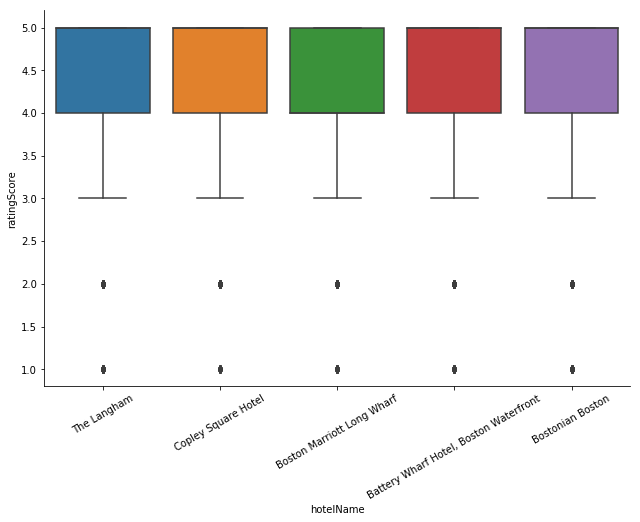

In [48]:
g = sns.factorplot(kind='box',        # Boxplot
               y='ratingScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/vlad/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


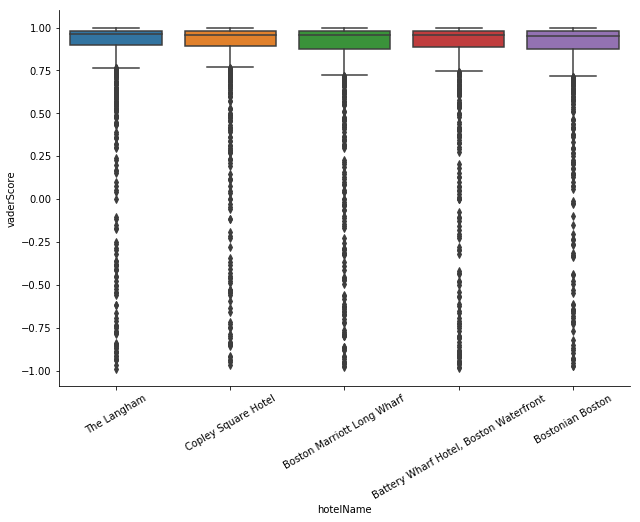

In [49]:
g = sns.factorplot(kind='box',        # Boxplot
               y='vaderScore',       # Y-axis - values for boxplot
               x='hotelName',        # X-axis - first factor
               data=tempdf,        # Dataframe 
               size=6,            # Figure size (x100px)      
               aspect=1.5,        # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot

for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticklabels(labels, rotation=30) # set new labels
    
plt.show()

/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


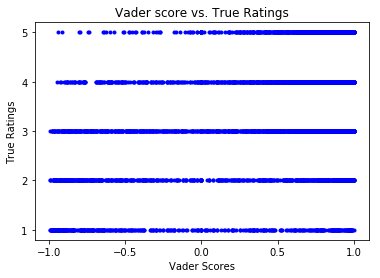

In [50]:
y = hotelDf['ratingScore'].as_matrix()
x = hotelDf['vaderScore'].as_matrix()
plt.title('Vader score vs. True Ratings')
plt.xlabel('Vader Scores')
plt.ylabel('True Ratings')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([1,2,3,4,5])
plt.plot(x, y, "o", ms=3, color='b')
plt.show()